<a href="https://colab.research.google.com/github/maanqii/coding_three_final/blob/main/style_transfer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

##This line imports the display module from IPython,
##popular interactive computing library. The display module provides functions to display various types of objects in Jupyter notebooks or IPython shells.
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

import tensorflow_hub as hub
from scipy.optimize import fmin_l_bfgs_b

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)

##This block of code checks if the tensor has more than three dimensions.
##If so, it asserts that the first dimension has a size of 1, ensuring that we are working with a single image.
##If the condition is met, the tensor is squeezed to remove the first dimension, resulting in a 3-dimensional tensor representing a single image.
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

  return PIL.Image.fromarray(tensor)

In [ ]:
##change picture from here:(download the path)
content_path = '/content/sample_data/content_butterfly.jpg'
style_path = '/content/sample_data/style3_14.jpg'

In [ ]:
def load_img(path_to_img):

##This line sets the maximum dimension for the image. If any side of the image is larger than this value, it will be resized while maintaining the aspect ratio.
##Even images with original values of 512 imported in multiples of 1024 work smoothly.
  max_dim = 1024
  img = tf.io.read_file(path_to_img)

##This line decodes the raw image data into a tensor using tf.image.decode_image. The channels=3 argument indicates that the image should have three color channels (RGB).
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

##These lines calculate the scaling factor (scale) based on the maximum dimension of the image (long_dim) and the desired maximum dimension (max_dim).
##It calculates the aspect ratio-preserving scaling factor for resizing the image.
  new_shape = tf.cast(shape * scale, tf.int32)

##This line computes the new shape of the image by multiplying the original shape with the scaling factor and casting it to an integer tensor.
##This line resizes the image tensor to the new shape using tf.image.resize. The resulting image will have dimensions specified by new_shape.
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

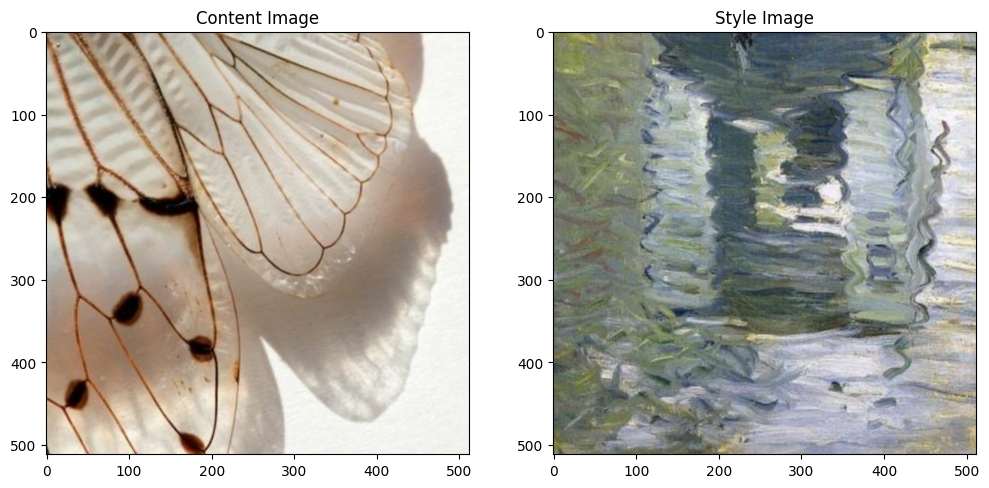

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

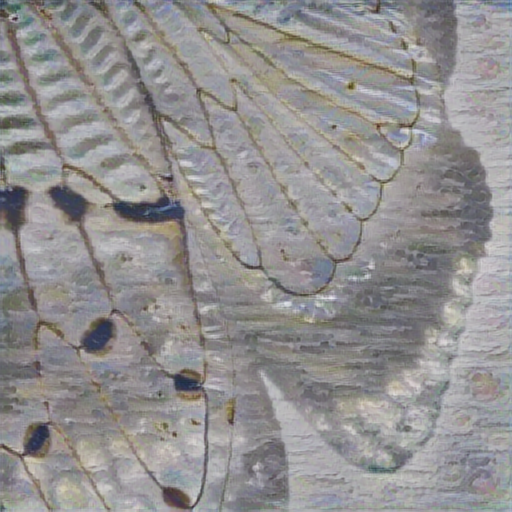

In [ ]:
## tensorflow model
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('harvestman', 0.31424376),
 ('necklace', 0.13922822),
 ('centipede', 0.06827772),
 ('mushroom', 0.051903535),
 ('quill', 0.04047096)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_50
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Select the output of the middle layer from the network to represent the style and content of the image:

In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Building models
The networks in tf.keras.applications allow you to easily extract intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

model = Model(inputs, outputs)

The following function constructs a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  835.42926
  mean:  23.11234

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  2620.854
  mean:  129.98409

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  7467.745
  mean:  110.26751

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  12598.393
  mean:  451.19058

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  1915.7909
  mean:  35.445126



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

Calling this model on an image returns the gram matrix (style) of `style_layers` and the contents of `content_layers`:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  61850.57
    mean:  258.0268

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  58573.754
    mean:  9091.604

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  259777.5
    mean:  9652.132

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2669007.2
    mean:  125488.62

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  84576.234
    mean:  1074.5106

Contents:
   block5_conv3
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  361.10452
    mean:  4.923848


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to represent the image to be optimised. To do this quickly, initialise it with the content image (`tf.Variable` must be the same shape as the content image)

In [ ]:
image = tf.Variable(content_image)

Since this is a floating point image, we define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

This tutorial recommends LBFGS, but Adam will also work fine:

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimise it, we use a weighted combination of two losses to obtain the total loss:

##
Code defines a function called style_content_loss that calculates the combined style and content loss given the model outputs.

The function takes outputs as input

The style loss is calculated by iterating over the style outputs and computing the mean squared difference between each style output and the corresponding style target. Thestyle_targets are not defined in the provided code snippet but are expected to contain the target style representations for each style layer. The squared differencestf.add_n and multiplied by style_weight / num_style_layers, where num_style_layers represents the number of style layers used.

Similarly, the content loss iscontent_targets are not defined in the given code but are expected tocontent_weight / num_content_layers, where num_content_layers represents the number of content layers used.

The style and content losses are then added together to obtain the final loss.

The style_content_loss function is responsible for quantifying the dissimilarity between the generated image and the style and content

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))



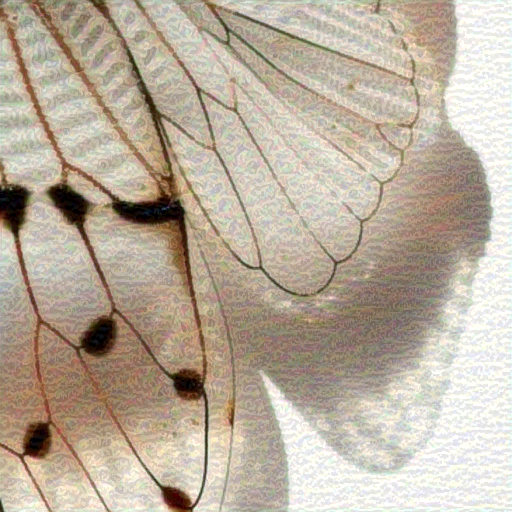

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

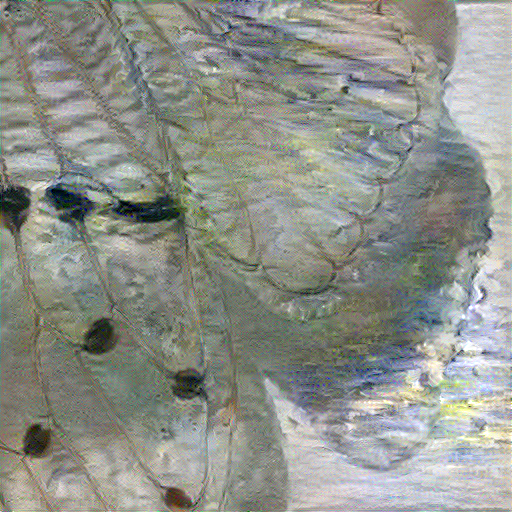

Train step: 1000
Total time: 90.0


In [ ]:
import time
start = time.time()

##The epoch value can be changed
epochs = 30
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variance loss
This implementation is only a basic version, and one of its drawbacks is that it generates a large number of high-frequency errors. We can reduce these high frequency errors directly by regularising the high frequency components of the image. In style transfer, this is often referred to as total variance loss:

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
  return x_var, y_var

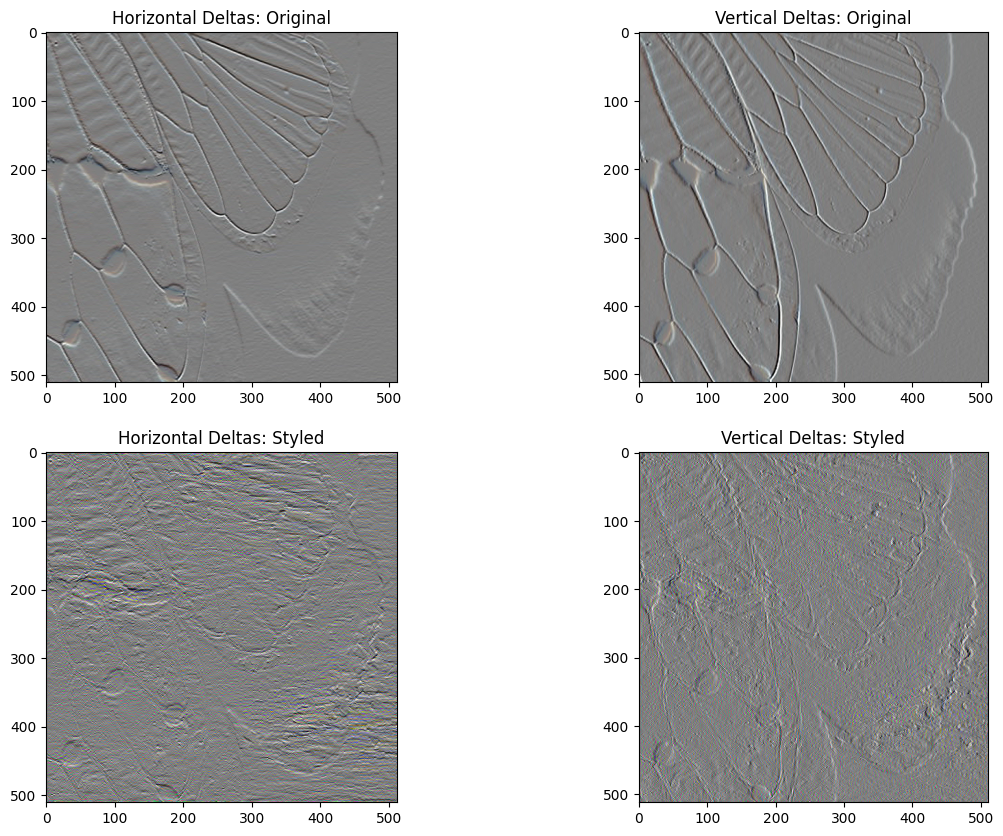

In [ ]:
##This code defines a function high_pass_x_y that takes an image as input and calculates the horizontal and vertical variations of the image.

##The horizontal variations (x_var) are computed by subtracting the image values shifted one pixel to the left (image[:, :, 1:, :]) from the original image values shifted one pixel to the right (image[:, :, :-1, :]).

##The vertical variations (y_var) are computed by subtracting the image values shifted one pixel up (image[:, 1:, :, :]) from the original image values shifted one pixel down (image[:, :-1, :, :]).

##The function returns the horizontal and vertical variations.

##The code then applies the high_pass_x_y function to the content_image to compute the original horizontal and vertical variations (x_deltas and y_deltas).

##Subsequently, the code plots the original horizontal and vertical variations using imshow and assigns titles to the subplots.

##Next, the high_pass_x_y function is applied to the image (styled image) to compute the horizontal and vertical variations (x_deltas and y_deltas) for the styled image.

##Finally, the code plots the horizontal and vertical variations of the styled image using imshow and assigns titles to the subplots.

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency component increases.

Also, essentially the high frequency component is an edge detector. We can obtain a similar output from the Sobel edge detector, for example

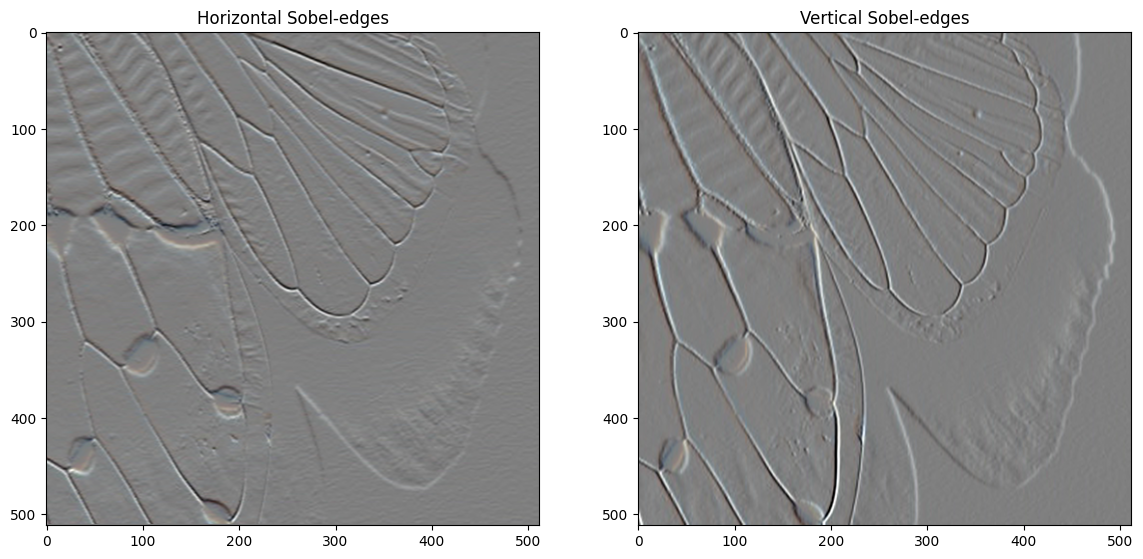

In [ ]:
##The tf.image.sobel_edges function computes the Sobel edges of the image, which represent the gradient magnitudes along the horizontal and vertical directions.

##The resulting sobel tensor contains two channels: the first channel (sobel[..., 0]) represents the horizontal edges, and the second channel (sobel[..., 1]) represents the vertical edges.

##The code then plots the horizontal Sobel edges using imshow, normalizing the values with clip_0_1 and scaling them by dividing by 4 and adding 0.5. The title "Horizontal Sobel-edges" is assigned to the subplot.

##Similarly, the vertical Sobel edges are plotted in the second subplot with the title "Vertical Sobel-edges".

##This visualization helps to understand the distribution and strength of edges in the content image, which can be useful for analyzing the image's structure and determining the style transfer effect on edge preservation.

plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularisation loss associated with this is the sum of the squares of these values:

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

90678.09

In [ ]:
tf.image.total_variation(image).numpy()

array([90678.09], dtype=float32)

In [ ]:
total_variation_weight=50

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

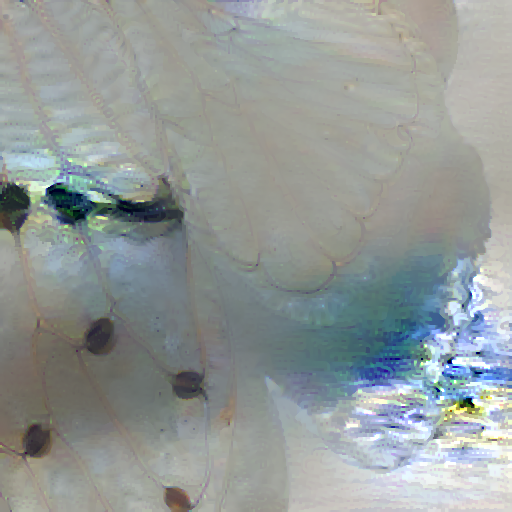

Train step: 3000
Total time: 274.6


In [ ]:
import time
start = time.time()

epochs = 30
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>